In [1]:
# pip install vncorenlp

In [2]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

The syntax of the command is incorrect.


'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'mv' is not recognized as an internal or external command,
operable program or batch file.
'mv' is not recognized as an internal or external command,
operable program or batch file.
'mv' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# pip install pyvi

In [3]:
# pip install tensorflow

In [4]:
# pip install keras


In [5]:
import vncorenlp
from vncorenlp import VnCoreNLP

# Đường dẫn đến mô hình VnCoreNLP đã tải xuống
rdrsegmenter = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx2g')

# Hàm tách từ
def word_tokenize(text):
    sentences = rdrsegmenter.tokenize(text)
    tokens = [token for sentence in sentences for token in sentence]
    return ' '.join(tokens)



**Data Loader**

In [6]:
TRAIN = 'data/train.csv'
# DEV = '/content/drive/MyDrive/mid_NLP/dev.csv'
# TEST = '/content/drive/MyDrive/mid_NLP/test.csv'

# LABEL = '/content/drive/MyDrive/mid_NLP/labels.csv'

import pandas as pd

train = pd.read_csv(TRAIN)
# dev = pd.read_csv(DEV)
# test = pd.read_csv(TEST)

# label = pd.read_csv(LABEL)
# job_types = label['job_type'].values

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
len(train)

20234

In [ ]:
len(dev)

1760

In [ ]:
len(test)

3933

In [ ]:
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [ ]:
# Evaluation metric
import sys
import os
import os.path
from scipy.stats import sem
import numpy as np
from ast import literal_eval
import tensorflow as tf

def em_score(y_true, y_pred):
    MR = np.all(y_pred == y_true, axis=1).mean()
    return MR

def accuracy_score(y_true, y_pred):
    temp = 0
    for i in range(0, len(y_true)):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / len(y_true)


def f1_score(y_true, y_pred):
    temp = 0
    for i in range(len(y_true)):
        if (sum(y_true[i]) == 0) and (sum(y_pred[i]) == 0):
            continue
        temp+= (2*sum(np.logical_and(y_true[i], y_pred[i]))) / (sum(y_true[i])+sum(y_pred[i]))
    return temp/ len(y_true)

In [ ]:
import numpy as np
import re
from pyvi import ViTokenizer

vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

def make_label(data):
    lbl_job = []
    for td in data['job'].values:
        l_job_onehot = np.zeros(len(job_types))

        for i in range(0, len(job_types)):
            if job_types[i] in td:
                l_job_onehot[i] = 1
        lbl_job.append(l_job_onehot)

    return lbl_job


def return_label(y):
    lbl_job = []
    for i in range(0, len(y)):
        if y[i] == 1:
            lbl_job.append(job_types[i])

    return lbl_job

def custom_tokenizer(text_data, tokenizer='vncorenlp'):
    # text_data = text_data.lower()
    if tokenizer == 'vncorenlp':
        # return " ".join(vncorenlp.tokenize(str(text_data))[0])
        text = ""
        lst = vncorenlp.tokenize(str(text_data))
        for t in lst:
            text += " ".join(t)
        return text
    if tokenizer == 'none':
        return text_data
    return ViTokenizer.tokenize(str(text_data))

def pre_process(X, y):
    sentences = []

    for t in X:
        t = re.sub(r"[-()\"#/@;:<>{}`+=~|!?,]", "", t)
        sentences.append(custom_tokenizer(t, tokenizer='vncorenlp'))



    return (sentences, y)

In [ ]:
y_train = make_label(train)
y_dev = make_label(dev)
y_test = make_label(test)

X_train = train['job_description']
X_dev = dev['job_description']
X_test = test['job_description']

In [ ]:
# Tiền xử lý dữ liệu
X_train, y_train = pre_process(X_train, y_train)
X_dev, y_dev = pre_process(X_dev, y_dev)
X_test, y_test = pre_process(X_test, y_test)


In [ ]:
len(X_train)

20234

In [ ]:
# Tách từ cho tất cả các văn bản trong tập dữ liệu
all_texts = X_train + X_dev + X_test

# Tách từ cho tất cả các văn bản
tokenized_texts = [text.split() for text in all_texts]


In [ ]:
tokenized_texts[0]

['Cung_cấp',
 'trợ_giúp',
 'cho',
 'khách_hàng',
 'sử_dụng',
 'các',
 'sản_phẩm',
 'hoặc',
 'dịch_vụ',
 'Giao_tiếp',
 'lịch_sự',
 'với',
 'khách_hàng',
 'qua',
 'điện_thoại',
 'email',
 'thư_từ',
 'và',
 'các',
 'kênh',
 'online',
 'khác',
 'Xem_xét',
 'và',
 'giải_quyết',
 'các',
 'vấn_đề',
 'của',
 'khách_hàng',
 'có_thể',
 'phức_tạp',
 'hoặc',
 'lâu_dài',
 'đã',
 'được',
 'các',
 'trợ_lý',
 'dịch_vụ',
 'khách_hàng',
 'chuyển_giao',
 'Xử_lý',
 'khiếu_nại',
 'của',
 'khách_hàng',
 'hoặc',
 'bất_kỳ',
 'sự_cố',
 'lớn',
 'nào',
 'chẳng_hạn',
 'như',
 'vấn_đề',
 'bảo_mật',
 'hoặc',
 'khách_hàng',
 'bị',
 'ốm',
 'Phân_tích',
 'số_liệu',
 'thống_kê',
 'hoặc',
 'dữ_liệu',
 'khác',
 'để',
 'xác_định',
 'mức_độ',
 'dịch_vụ',
 'khách_hàng',
 'Tham_mưu',
 'Cải_thiện',
 'các',
 'thủ_tục',
 'chính_sách',
 'và',
 'tiêu_chuẩn',
 'dịch_vụ',
 'khách_hàng',
 'Phối_hợp',
 'tốt',
 'với',
 'các',
 'bộ_phận',
 'khác',
 'để',
 'thảo_luận',
 'về',
 'những',
 'cải_tiến',
 'có_thể',
 'có',
 'đối_với',
 'dịch_v

In [ ]:
# Huấn luyện mô hình Word2Vec
embedding_dim = 50  # Kích thước của embeddings - 100
word2vec_model = Word2Vec(tokenized_texts, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Lưu trữ embeddings
word_vectors = word2vec_model.wv

In [ ]:
# Chuyển đổi văn bản thành chuỗi số dựa trên từ điển Word2Vec
def text_to_sequence(text, word_vectors):
    return [word_vectors.key_to_index[word] if word in word_vectors else 0 for word in text.split()]

# Chuyển đổi các văn bản trong tập train, dev và test
train_sequences = [text_to_sequence(text, word_vectors) for text in X_train]
dev_sequences = [text_to_sequence(text, word_vectors) for text in X_dev]
test_sequences = [text_to_sequence(text, word_vectors) for text in X_test]


In [ ]:
# Đệm các chuỗi để tất cả đều có độ dài như nhau
maxlen = 100
X_train = pad_sequences(train_sequences, maxlen=maxlen)
X_dev = pad_sequences(dev_sequences, maxlen=maxlen)
X_test = pad_sequences(test_sequences, maxlen=maxlen)


In [ ]:
# Chuyển đổi nhãn sang định dạng nhị phân
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_dev = mlb.transform(y_dev)
y_test = mlb.transform(y_test)

In [ ]:
# Tạo ma trận embeddings
vocab_size = len(word_vectors)
embedding_matrix = np.zeros((vocab_size + 2, embedding_dim))

# Điền ma trận embeddings với các vectors từ Word2Vec
for word, i in word_vectors.key_to_index.items():
    embedding_vector = word_vectors[word]
    if embedding_vector is not None:
        embedding_matrix[i + 2] = embedding_vector

# Thêm embeddings ngẫu nhiên cho các từ đặc biệt UNK và PAD
embedding_matrix[1] = np.random.randn(embedding_dim)  # UNK
embedding_matrix[0] = np.zeros(embedding_dim)  # PAD

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, Flatten, LSTM, GRU, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

In [ ]:
# Xây dựng mô hình FFNN
model_ffnn = Sequential()
model_ffnn.add(Embedding(input_dim=vocab_size + 2, output_dim=embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model_ffnn.add(Flatten())
model_ffnn.add(Dense(256, activation='relu'))
model_ffnn.add(BatchNormalization())
model_ffnn.add(Dropout(0.5))
model_ffnn.add(Dense(128, activation='relu'))
model_ffnn.add(BatchNormalization())
model_ffnn.add(Dropout(0.5))
model_ffnn.add(Dense(y_train.shape[1], activation='sigmoid'))

In [ ]:
model_ffnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           2247000   
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 256)               1280256   
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                        

In [ ]:
model_ffnn.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [ ]:
# Thiết lập EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Huấn luyện mô hình
history_ffnn = model_ffnn.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_dev, y_dev), callbacks=[early_stopping])


Epoch 1/20
317/317 [==============================] - 10s 27ms/step - loss: 0.3661 - accuracy: 0.5693 - val_loss: 0.0309 - val_accuracy: 0.9256
Epoch 2/20
317/317 [==============================] - 9s 27ms/step - loss: 0.0263 - accuracy: 0.6142 - val_loss: 0.0044 - val_accuracy: 0.8841
Epoch 3/20
317/317 [==============================] - 8s 27ms/step - loss: 0.0068 - accuracy: 0.6025 - val_loss: 0.0016 - val_accuracy: 0.8818
Epoch 4/20
317/317 [==============================] - 7s 21ms/step - loss: 0.0031 - accuracy: 0.5975 - val_loss: 8.7144e-04 - val_accuracy: 0.8597
Epoch 5/20
317/317 [==============================] - 8s 26ms/step - loss: 0.0017 - accuracy: 0.5872 - val_loss: 4.5793e-04 - val_accuracy: 0.7415
Epoch 6/20
317/317 [==============================] - 7s 21ms/step - loss: 0.0010 - accuracy: 0.5859 - val_loss: 2.9114e-04 - val_accuracy: 0.8108
Epoch 7/20
317/317 [==============================] - 9s 27ms/step - loss: 7.2816e-04 - accuracy: 0.5749 - val_loss: 1.7971e-04 -

In [ ]:
import matplotlib.pyplot as plt

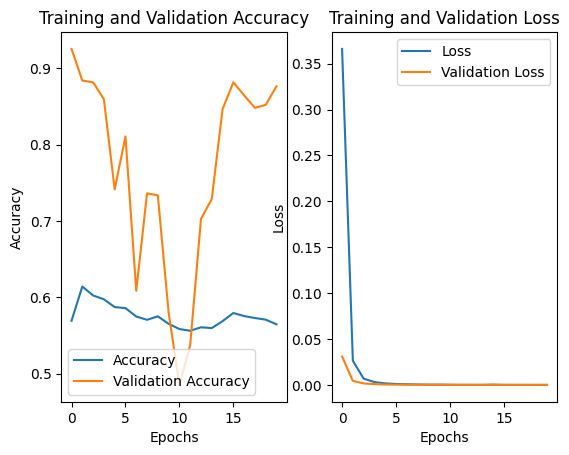

In [ ]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history_ffnn.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

In [ ]:
# Đánh giá mô hình FFNN
ffnn_score = model_ffnn.evaluate(X_test, y_test, batch_size=64)
print(f'FFNN Test loss: {ffnn_score[0]}')
print(f'FFNN Test accuracy: {ffnn_score[1]}')

62/62 [==============================] - 0s 7ms/step - loss: 7.2196e-06 - accuracy: 0.8958
FFNN Test loss: 7.21956166671589e-06
FFNN Test accuracy: 0.8957538604736328


In [ ]:
# Xây dựng mô hình RNN
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=vocab_size + 2, output_dim=embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False))
model_rnn.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.5))
model_rnn.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model_rnn.add(BatchNormalization())
# model_rnn.add(GRU(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))  # Sử dụng GRU thay vì LSTM và giảm số lượng nơron
# model_rnn.add(BatchNormalization())
# model_rnn.add(Dropout(0.5))
# model_rnn.add(GRU(64, dropout=0.2, recurrent_dropout=0.2))
# model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(y_train.shape[1], activation='sigmoid'))

In [ ]:
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           2247000   
                                                                 
 lstm (LSTM)                 (None, 100, 64)           29440     
                                                                 
 batch_normalization_2 (Bat  (None, 100, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                     

In [ ]:
# Biên dịch mô hình
model_rnn.compile(loss='binary_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])


In [ ]:
# Thiết lập EarlyStopping
early_stopping_rnn = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Huấn luyện mô hình
history_rnn = model_rnn.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_dev, y_dev), callbacks=[early_stopping_rnn])


Epoch 1/20
317/317 [==============================] - 127s 373ms/step - loss: 0.4632 - accuracy: 0.5595 - val_loss: 0.0518 - val_accuracy: 0.9375
Epoch 2/20
317/317 [==============================] - 109s 343ms/step - loss: 0.0511 - accuracy: 0.6172 - val_loss: 0.0064 - val_accuracy: 0.8790
Epoch 3/20
317/317 [==============================] - 113s 356ms/step - loss: 0.0115 - accuracy: 0.6170 - val_loss: 0.0017 - val_accuracy: 0.8886
Epoch 4/20
317/317 [==============================] - 110s 345ms/step - loss: 0.0051 - accuracy: 0.6134 - val_loss: 7.2377e-04 - val_accuracy: 0.9034
Epoch 5/20
317/317 [==============================] - 111s 350ms/step - loss: 0.0027 - accuracy: 0.6038 - val_loss: 4.1670e-04 - val_accuracy: 0.8943
Epoch 6/20
317/317 [==============================] - 109s 343ms/step - loss: 0.0015 - accuracy: 0.6043 - val_loss: 2.4846e-04 - val_accuracy: 0.8682
Epoch 7/20
317/317 [==============================] - 109s 343ms/step - loss: 0.0011 - accuracy: 0.5948 - val_lo

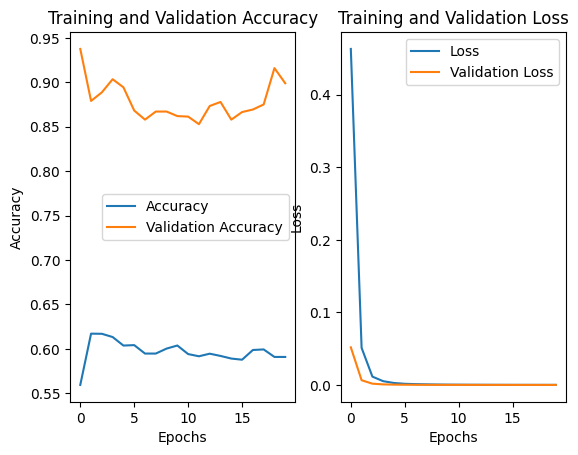

In [ ]:
# Plotting the accuracy and loss over time

# Training history
history_dict = history_rnn.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

In [ ]:
# Đánh giá mô hình RNN
rnn_score = model_rnn.evaluate(X_test, y_test, batch_size=64)
print(f'RNN Test loss: {rnn_score[0]}')
print(f'RNN Test accuracy: {rnn_score[1]}')

62/62 [==============================] - 3s 51ms/step - loss: 3.9413e-06 - accuracy: 0.9062
RNN Test loss: 3.941333488910459e-06
RNN Test accuracy: 0.9061784744262695
